
### 라이브러리 import

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [ ]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=10, forward=0):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [ ]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [ ]:
from sklearn.model_selection import train_test_split

# train/validation/test 분리 함수
def split_train_val_test(df, test_size=0.2, val_size=0.25):

    #Train, Test 분류
    train_val_df, test_df = train_test_split(df, test_size=test_size, shuffle=False)

    #Train, Validation 분류
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, shuffle=False)

    # # 데이터 크기 출력
    # print("Train set:", train_df.shape)
    # print("Validation set:", val_df.shape)
    # print("Test set:", test_df.shape)

    return train_df, val_df, test_df

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [ ]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# splited 데이터 경로 시각화 함수
def plot_trajectory(train_data, val_data, test_data):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # 훈련 데이터 플롯
    ax.plot(train_data['lat'], train_data['lon'], train_data['alt'], label='Train', color='blue')

    # 검증 데이터 플롯
    ax.plot(val_data['lat'], val_data['lon'], val_data['alt'], label='Validation', color='green')

    # 테스트 데이터 플롯
    ax.plot(test_data['lat'], test_data['lon'], test_data['alt'], label='Test', color='red')

    # 그래프 레이블
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 제목과 범례
    ax.set_title('Drone Trajectory: Train, Validation, and Test')
    ax.legend()

    plt.show()


### 7. 데이터로더 생성 함수

- 학습에 사용할 데이터 로더 생성
1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader 생성

In [ ]:
# 데이터 로더 생성 함수
def create_dataloaders(tri, batch_size, sequence_length):

  tri = tri[['time', 'lat', 'lon', 'alt']]

  # train, validation, test 분리
  train_data, val_data, test_data = split_train_val_test(tri)

  # 각 데이터셋에서 시퀀스 생성
  X_train, y_train = create_sequences(train_data[['lat', 'lon', 'alt']], look_back=sequence_length)
  X_val, y_val = create_sequences(val_data[['lat', 'lon', 'alt']], look_back=sequence_length)
  X_test, y_test = create_sequences(test_data[['lat', 'lon', 'alt']], look_back=sequence_length)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  # 데이터 로더 생성
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

## 전처리

### 1. 데이터셋 가져오기

In [ ]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("OnboardGPS.csv")

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [ ]:
tri = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lat'])
new_x, lon = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lon'])
new_x, alt = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' alt'])

tri = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

tri = truncation(tri)
scaler, tri = min_max_scaling(tri)
# tri

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- Transformer를 사용한 모델 클래스 선언
- 구조 : Transformer + Positional Encoding + Fully Connected Layer

In [ ]:
import math
import torch

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.pe[:, 0::2] = torch.sin(position * div_term)  # Even indices

        self.pe = self.pe.unsqueeze(0)

    def forward(self, x):
        if self.pe.shape[2] != x.shape[2]:
            raise ValueError(f"Positional encoding dim {self.pe.shape[2]} does not match input dim {x.shape[2]}")

        x = x + self.pe[:, :x.size(1), :].to(x.device)  # Add positional encoding
        return self.dropout(x)

In [ ]:
import torch.nn as nn
import torch

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim=3, d_model=64, nhead=4, num_encoder_layers=2, dim_feedforward=512, dropout=0.0):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model,
                                       nhead=nhead,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout,
                                       batch_first=True  # batch_first 사용
            ),
            num_layers=num_encoder_layers
        )

        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, src):
        # embedding과 positional encoding 적용
        src = self.embedding(src)
        src = self.positional_encoding(src)

        # transformer encoder 통과 (batch_first=True이므로 permute 필요 없음)
        output = self.transformer_encoder(src)

        # fully connected layer 통과
        output = self.fc_out(output)

        return output[:, -1, :]  # 마지막 시퀀스의 출력만 반환


## 하이퍼파라미터 탐색

### 1. Optuna의 objective 함수 선언

- 최적의 하이퍼파라미터 탐색을 위해 optuna 사용
- objective 함수 선언

In [ ]:
def objective(trial, train_data, sequence_length):
    nhead = trial.suggest_int('nhead', 2, 8)

    d_model = trial.suggest_int('d_model', nhead * 8, nhead * 64, step=nhead)
    if d_model % 2 != 0:
        d_model += 1
    if d_model % nhead != 0:
        d_model += nhead - (d_model % nhead)

    num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 4)
    dim_feedforward = trial.suggest_int('dim_feedforward', 128, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_int('batch_size', 16, 128)

    ## 값 지정
    num_epochs = 632
    input_size = 3    # lat, lon, alt
    output_size = 3    # lat, lon, alt
    dropout = 0.0

    # 데이터 로더 생성
    train_loader, val_loader, _ = create_dataloaders(train_data, batch_size, sequence_length)

    # Transformer model 정의
    model = TransformerModel(
        input_dim=input_size,
        output_dim=output_size,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss function
    criterion = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_val_loss = 0.0
    val_loss_count = 0

    # 모델 학습
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                output = model(batch_x)
                loss = criterion(output, batch_y)
                val_loss += loss.item()

        val_loss_avg = val_loss / len(val_loader)

        trial.report(val_loss_avg, epoch)

        total_val_loss += val_loss_avg
        val_loss_count += 1

        if trial.should_prune():
            print(f"Trial {trial.number} pruned at epoch {epoch}")
            raise optuna.TrialPruned()

    return total_val_loss / val_loss_count

### 3. 탐색 범위 외의 하이퍼파라미터 선언

In [ ]:
sequence_length = 10
early_stopping_rounds = 10
n_trials = 100

### 4. 하이퍼 파라미터 탐색

In [ ]:
import optuna

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(lambda trial: objective(trial, tri, sequence_length), n_trials=n_trials)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)


[I 2024-10-20 06:00:40,978] A new study created in memory with name: no-name-e83a53b1-622b-41b8-8747-2fe2f026d783
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:03:00,831] Trial 0 finished with value: 0.10782244456207579 and parameters: {'nhead': 7, 'd_model': 140, 'num_encoder_layers': 4, 'dim_feedforward': 484, 'learning_rate': 0.008536181470003566, 'batch_size': 91}. Best is trial 0 with value: 0.10782244456207579.
[I 2024-10-20 06:04:05,456] Trial 1 finished with value: 0.0001894787711323905 and parameters: {'nhead': 2, 'd_model': 46, 'num_encoder_layers': 1, 'dim_feedforward': 205, 'learning_rate': 0.005284555881171683, 'batch_size': 68}. Best is trial 1 with value: 0.0001894787711323905.

Trial 6 pruned at epoch 10


[I 2024-10-20 06:15:44,736] Trial 7 finished with value: 0.0012493968314843994 and parameters: {'nhead': 2, 'd_model': 108, 'num_encoder_layers': 2, 'dim_feedforward': 192, 'learning_rate': 0.004829699372700072, 'batch_size': 42}. Best is trial 1 with value: 0.0001894787711323905.
[I 2024-10-20 06:15:46,900] Trial 8 pruned. 


Trial 8 pruned at epoch 12


[I 2024-10-20 06:19:09,629] Trial 9 finished with value: 0.00027805196672706344 and parameters: {'nhead': 2, 'd_model': 116, 'num_encoder_layers': 1, 'dim_feedforward': 305, 'learning_rate': 0.006187829946953618, 'batch_size': 20}. Best is trial 1 with value: 0.0001894787711323905.
[I 2024-10-20 06:19:14,110] Trial 10 pruned. 


Trial 10 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:19:22,905] Trial 11 pruned. 


Trial 11 pruned at epoch 10


[I 2024-10-20 06:20:40,298] Trial 12 finished with value: 0.00017999771655505975 and parameters: {'nhead': 4, 'd_model': 32, 'num_encoder_layers': 1, 'dim_feedforward': 234, 'learning_rate': 0.0059710399495214615, 'batch_size': 56}. Best is trial 12 with value: 0.00017999771655505975.
[I 2024-10-20 06:20:45,241] Trial 13 pruned. 


Trial 13 pruned at epoch 10


[I 2024-10-20 06:23:00,649] Trial 14 finished with value: 0.0007139240107647362 and parameters: {'nhead': 4, 'd_model': 56, 'num_encoder_layers': 2, 'dim_feedforward': 149, 'learning_rate': 0.005845293409684917, 'batch_size': 46}. Best is trial 12 with value: 0.00017999771655505975.
[I 2024-10-20 06:23:58,464] Trial 15 finished with value: 0.00013127944479850032 and parameters: {'nhead': 6, 'd_model': 282, 'num_encoder_layers': 1, 'dim_feedforward': 243, 'learning_rate': 0.0002335571657438515, 'batch_size': 82}. Best is trial 15 with value: 0.00013127944479850032.
[I 2024-10-20 06:24:02,474] Trial 16 pruned. 


Trial 16 pruned at epoch 19


[I 2024-10-20 06:25:56,271] Trial 17 finished with value: 0.00022488914305140057 and parameters: {'nhead': 6, 'd_model': 282, 'num_encoder_layers': 3, 'dim_feedforward': 343, 'learning_rate': 0.00020282775610472632, 'batch_size': 80}. Best is trial 15 with value: 0.00013127944479850032.
[I 2024-10-20 06:26:00,891] Trial 18 pruned. 


Trial 18 pruned at epoch 10


[I 2024-10-20 06:26:03,306] Trial 19 pruned. 


Trial 19 pruned at epoch 10


[I 2024-10-20 06:26:07,621] Trial 20 pruned. 


Trial 20 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:27:18,483] Trial 21 finished with value: 0.00037749716165152167 and parameters: {'nhead': 3, 'd_model': 90, 'num_encoder_layers': 1, 'dim_feedforward': 222, 'learning_rate': 0.005308576166907506, 'batch_size': 65}. Best is trial 15 with value: 0.00013127944479850032.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:28:25,753] Trial 22 finished with value: 0

Trial 24 pruned at epoch 10


[I 2024-10-20 06:31:11,975] Trial 25 finished with value: 0.00019409152748919907 and parameters: {'nhead': 4, 'd_model': 164, 'num_encoder_layers': 2, 'dim_feedforward': 178, 'learning_rate': 0.0010813252652926552, 'batch_size': 87}. Best is trial 22 with value: 0.00011328023391674454.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:32:14,002] Trial 26 finished with value: 0.00013327145916456294 and parameters: {'nhead': 3, 'd_model': 78, 'num_encoder_layers': 1, 'dim_feedforward': 226, 'learning_rate': 0.0025701849335985037, 'batch_size': 74}. Best is trial 22 with value: 0.00011328023391674454.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_ne

Trial 28 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:33:24,419] Trial 29 pruned. 


Trial 29 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:33:26,543] Trial 30 pruned. 


Trial 30 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:34:31,391] Trial 31 finished with value: 0.00020260551857094336 and parameters: {'nhead': 3, 'd_model': 27, 'num_encoder_layers': 1, 'dim_feedforward': 234, 'learning_rate': 0.0032654510895692977, 'batch_size': 71}. Best is trial 22 with value: 0.00011328023391674454.
[I 2024-10-20 06:34:33,885] Trial 32 pruned. 


Trial 32 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:35:56,972] Trial 33 finished with value: 0.00023634043218286624 and parameters: {'nhead': 3, 'd_model': 45, 'num_encoder_layers': 1, 'dim_feedforward': 231, 'learning_rate': 0.006792197459404135, 'batch_size': 54}. Best is trial 22 with value: 0.00011328023391674454.
[I 2024-10-20 06:36:55,702] Trial 34 finished with value: 0.00018320002297270683 and parameters: {'nhead': 4, 'd_model': 72, 'num_encoder_layers': 1, 'dim_feedforward': 187, 'learning_rate': 0.0052145901930647515, 'batch_size': 78}. Best is trial 22 with value: 0.00011328023391674454.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nest

Trial 37 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:39:52,008] Trial 38 pruned. 


Trial 38 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:39:56,731] Trial 39 pruned. 


Trial 39 pruned at epoch 10


[I 2024-10-20 06:40:01,797] Trial 40 pruned. 


Trial 40 pruned at epoch 10


[I 2024-10-20 06:41:42,368] Trial 41 finished with value: 0.00012686211224896473 and parameters: {'nhead': 6, 'd_model': 102, 'num_encoder_layers': 2, 'dim_feedforward': 128, 'learning_rate': 0.0007754845949548258, 'batch_size': 64}. Best is trial 22 with value: 0.00011328023391674454.
[I 2024-10-20 06:42:51,532] Trial 42 finished with value: 0.00010203957295066081 and parameters: {'nhead': 6, 'd_model': 78, 'num_encoder_layers': 1, 'dim_feedforward': 135, 'learning_rate': 0.001485492982765131, 'batch_size': 64}. Best is trial 42 with value: 0.00010203957295066081.
[I 2024-10-20 06:42:55,310] Trial 43 pruned. 


Trial 43 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:43:01,462] Trial 44 pruned. 


Trial 44 pruned at epoch 12


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:43:04,728] Trial 45 pruned. 


Trial 45 pruned at epoch 10


[I 2024-10-20 06:43:08,635] Trial 46 pruned. 


Trial 46 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:44:58,253] Trial 47 finished with value: 0.0003837342821909971 and parameters: {'nhead': 7, 'd_model': 308, 'num_encoder_layers': 2, 'dim_feedforward': 195, 'learning_rate': 0.0011701772585754199, 'batch_size': 61}. Best is trial 42 with value: 0.00010203957295066081.
[I 2024-10-20 06:46:52,114] Trial 48 finished with value: 0.00013337071837703552 and parameters: {'nhead': 6, 'd_model': 72, 'num_encoder_layers': 1, 'dim_feedforward': 466, 'learning_rate': 0.002042124472935435, 'batch_size': 37}. Best is trial 42 with value: 0.00010203957295066081.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nest

Trial 49 pruned at epoch 10


[I 2024-10-20 06:46:59,239] Trial 50 pruned. 


Trial 50 pruned at epoch 10


[I 2024-10-20 06:47:01,498] Trial 51 pruned. 


Trial 51 pruned at epoch 10


[I 2024-10-20 06:47:03,883] Trial 52 pruned. 


Trial 52 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:47:06,419] Trial 53 pruned. 


Trial 53 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:48:16,059] Trial 54 finished with value: 0.00010597924648579333 and parameters: {'nhead': 3, 'd_model': 48, 'num_encoder_layers': 1, 'dim_feedforward': 215, 'learning_rate': 0.0030898730228369987, 'batch_size': 65}. Best is trial 42 with value: 0.00010203957295066081.
[I 2024-10-20 06:49:41,183] Trial 55 finished with value: 0.00018947032134764347 and parameters: {'nhead': 6, 'd_model': 60, 'num_encoder_layers': 1, 'dim_feedforward': 304, 'learning_rate': 0.003096942311074385, 'batch_size': 51}. Best is trial 42 with value: 0.00010203957295066081.
[I 2024-10-20 06:49:45,167] Trial 56 pruned. 


Trial 56 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:49:47,818] Trial 57 pruned. 


Trial 57 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:49:50,103] Trial 58 pruned. 


Trial 58 pruned at epoch 10


[I 2024-10-20 06:49:55,554] Trial 59 pruned. 


Trial 59 pruned at epoch 11


[I 2024-10-20 06:49:58,926] Trial 60 pruned. 


Trial 60 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:50:01,295] Trial 61 pruned. 


Trial 61 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:50:04,041] Trial 62 pruned. 


Trial 62 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:50:06,979] Trial 63 pruned. 


Trial 63 pruned at epoch 11


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:50:09,127] Trial 64 pruned. 


Trial 64 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:50:11,867] Trial 65 pruned. 


Trial 65 pruned at epoch 10


[I 2024-10-20 06:51:24,115] Trial 66 finished with value: 0.00015012752687581523 and parameters: {'nhead': 4, 'd_model': 80, 'num_encoder_layers': 1, 'dim_feedforward': 163, 'learning_rate': 0.003551648944362168, 'batch_size': 62}. Best is trial 42 with value: 0.00010203957295066081.
[I 2024-10-20 06:51:26,567] Trial 67 pruned. 


Trial 67 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 06:52:56,634] Trial 68 finished with value: 0.0002574849402431029 and parameters: {'nhead': 3, 'd_model': 66, 'num_encoder_layers': 2, 'dim_feedforward': 197, 'learning_rate': 0.0024715011020735437, 'batch_size': 75}. Best is trial 42 with value: 0.00010203957295066081.
[I 2024-10-20 06:52:58,811] Trial 69 pruned. 


Trial 69 pruned at epoch 10


[I 2024-10-20 06:54:12,843] Trial 70 finished with value: 0.00014414063646953494 and parameters: {'nhead': 4, 'd_model': 128, 'num_encoder_layers': 1, 'dim_feedforward': 234, 'learning_rate': 0.0011378559767711925, 'batch_size': 60}. Best is trial 42 with value: 0.00010203957295066081.
[I 2024-10-20 06:54:17,749] Trial 71 pruned. 


Trial 71 pruned at epoch 10


[I 2024-10-20 06:56:43,473] Trial 72 finished with value: 8.157074541114356e-05 and parameters: {'nhead': 6, 'd_model': 72, 'num_encoder_layers': 1, 'dim_feedforward': 371, 'learning_rate': 0.0020775574209444224, 'batch_size': 28}. Best is trial 72 with value: 8.157074541114356e-05.
[I 2024-10-20 07:00:49,304] Trial 73 finished with value: 6.446202626657779e-05 and parameters: {'nhead': 6, 'd_model': 60, 'num_encoder_layers': 1, 'dim_feedforward': 388, 'learning_rate': 0.0032745550105121894, 'batch_size': 16}. Best is trial 73 with value: 6.446202626657779e-05.
[I 2024-10-20 07:03:31,724] Trial 74 finished with value: 7.159283516215127e-05 and parameters: {'nhead': 6, 'd_model': 60, 'num_encoder_layers': 1, 'dim_feedforward': 394, 'learning_rate': 0.003226816346668826, 'batch_size': 25}. Best is trial 73 with value: 6.446202626657779e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is

Trial 75 pruned at epoch 10


[I 2024-10-20 07:03:55,613] Trial 76 pruned. 


Trial 76 pruned at epoch 10


[I 2024-10-20 07:08:00,286] Trial 77 finished with value: 0.00022088970498913886 and parameters: {'nhead': 6, 'd_model': 60, 'num_encoder_layers': 1, 'dim_feedforward': 389, 'learning_rate': 0.004351302512107263, 'batch_size': 16}. Best is trial 73 with value: 6.446202626657779e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 07:08:06,999] Trial 78 pruned. 


Trial 78 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 07:08:13,003] Trial 79 pruned. 


Trial 79 pruned at epoch 11


[I 2024-10-20 07:08:28,416] Trial 80 pruned. 


Trial 80 pruned at epoch 10


[I 2024-10-20 07:08:34,751] Trial 81 pruned. 


Trial 81 pruned at epoch 10


[I 2024-10-20 07:08:42,808] Trial 82 pruned. 


Trial 82 pruned at epoch 16


[I 2024-10-20 07:12:49,921] Trial 83 finished with value: 5.6448747688355184e-05 and parameters: {'nhead': 6, 'd_model': 72, 'num_encoder_layers': 1, 'dim_feedforward': 409, 'learning_rate': 0.0014676821347472486, 'batch_size': 16}. Best is trial 83 with value: 5.6448747688355184e-05.
[I 2024-10-20 07:16:55,638] Trial 84 finished with value: 6.585862338273701e-05 and parameters: {'nhead': 6, 'd_model': 72, 'num_encoder_layers': 1, 'dim_feedforward': 415, 'learning_rate': 0.002194066219132264, 'batch_size': 16}. Best is trial 83 with value: 5.6448747688355184e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 07:21:04,217] Trial 85 finished with value: 7.300455904832717e-05 and parameters: {'nhea

Trial 89 pruned at epoch 11


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 07:34:51,441] Trial 90 finished with value: 0.0020013102049700575 and parameters: {'nhead': 7, 'd_model': 91, 'num_encoder_layers': 1, 'dim_feedforward': 386, 'learning_rate': 0.0027248839209016587, 'batch_size': 23}. Best is trial 83 with value: 5.6448747688355184e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 07:38:23,784] Trial 91 finished with value: 6

Trial 96 pruned at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 07:57:44,210] Trial 97 finished with value: 0.00015348452140669599 and parameters: {'nhead': 5, 'd_model': 60, 'num_encoder_layers': 1, 'dim_feedforward': 424, 'learning_rate': 0.00389825323499315, 'batch_size': 21}. Best is trial 83 with value: 5.6448747688355184e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-20 08:01:28,762] Trial 98 finished with value: 8.

Trial 99 pruned at epoch 10
Best hyperparameters:  {'nhead': 6, 'd_model': 72, 'num_encoder_layers': 1, 'dim_feedforward': 409, 'learning_rate': 0.0014676821347472486, 'batch_size': 16}


### 5. 하이퍼파라미터 저장

In [ ]:
import json

### 하이퍼 파라미터 저장

# 최적의 하이퍼파라미터를 JSON 파일로 저장
with open("best_hyperparameters.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best hyperparameters have been saved to 'best_hyperparameters.json'")

Best hyperparameters have been saved to 'best_hyperparameters.json'


## 학습

### 1. 하이퍼파라미터 불러오기

In [ ]:
import json

# 저장된 하이퍼파라미터 불러오기
with open("best_hyperparameters.json", "r") as f:
    best_params = json.load(f)

print("Loaded best hyperparameters:", best_params)

Loaded best hyperparameters: {'nhead': 6, 'd_model': 72, 'num_encoder_layers': 1, 'dim_feedforward': 409, 'learning_rate': 0.0014676821347472486, 'batch_size': 16}


### 2. 최적의 파라미터로 모델 학습

In [ ]:
sequence_length = 10
num_epochs = 632

In [ ]:
# 최적의 모델 학습
# best_params = study.best_params

train_loader, val_loader, test_loader = create_dataloaders(tri, best_params['batch_size'], sequence_length)

best_model = TransformerModel(
    input_dim=3,
    d_model=best_params['d_model'],
    nhead=best_params['nhead'],
    num_encoder_layers=best_params['num_encoder_layers'],
    dim_feedforward=best_params['dim_feedforward']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = torch.nn.MSELoss()

In [ ]:
import time
import torch

# 학습 및 검증 손실을 기록할 리스트
train_losses = []
val_losses = []

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수

for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
            batch_y = batch_y.to(device)
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

    # 평균 손실 계산 및 저장
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 모델 저장
    if (epoch + 1) % 100 == 0 or epoch + 1 == 632:

      # Model Save
      model_save_path = f"./output_model/best_model_epoch_{epoch+1}.pth"
      torch.save({
        'model_state_dict': best_model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses
      }, model_save_path)
      print(f"Model saved: {model_save_path}")

    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")


Epoch [1/300], Train Loss: 2.7335, Val Loss: 0.0136
Epoch 1/300 completed in 0.74 seconds.
Epoch [2/300], Train Loss: 0.0159, Val Loss: 0.0073
Epoch 2/300 completed in 0.75 seconds.
Epoch [3/300], Train Loss: 0.0094, Val Loss: 0.0062
Epoch 3/300 completed in 0.75 seconds.
Epoch [4/300], Train Loss: 0.0089, Val Loss: 0.0062
Epoch 4/300 completed in 0.75 seconds.
Epoch [5/300], Train Loss: 0.0069, Val Loss: 0.0097
Epoch 5/300 completed in 0.75 seconds.
Epoch [6/300], Train Loss: 0.0085, Val Loss: 0.0167
Epoch 6/300 completed in 0.76 seconds.
Epoch [7/300], Train Loss: 0.0088, Val Loss: 0.0181
Epoch 7/300 completed in 0.77 seconds.
Epoch [8/300], Train Loss: 0.0129, Val Loss: 0.0111
Epoch 8/300 completed in 0.75 seconds.
Epoch [9/300], Train Loss: 0.0148, Val Loss: 0.0073
Epoch 9/300 completed in 0.80 seconds.
Epoch [10/300], Train Loss: 0.0171, Val Loss: 0.0090
Epoch 10/300 completed in 0.94 seconds.
Epoch [11/300], Train Loss: 0.0107, Val Loss: 0.0041
Epoch 11/300 completed in 1.02 seco

### 3. 모델 요약 내용 출력

In [ ]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModel                              [1, 3]                    --
├─Linear: 1-1                                 [1, 10, 72]               288
├─PositionalEncoding: 1-2                     [1, 10, 72]               --
│    └─Dropout: 2-1                           [1, 10, 72]               --
├─TransformerEncoder: 1-3                     [1, 10, 72]               --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 10, 72]               80,689
├─Linear: 1-4                                 [1, 10, 3]                219
Total params: 81,196
Trainable params: 81,196
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

## 테스트

### 1. 테스트 결과 생성

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# 모델 예측 및 성능 평가
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = best_model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 4.783308759215288e-05
Mean Absolute Error (MAE): 0.004623540211468935


### 2. 결과 시각화

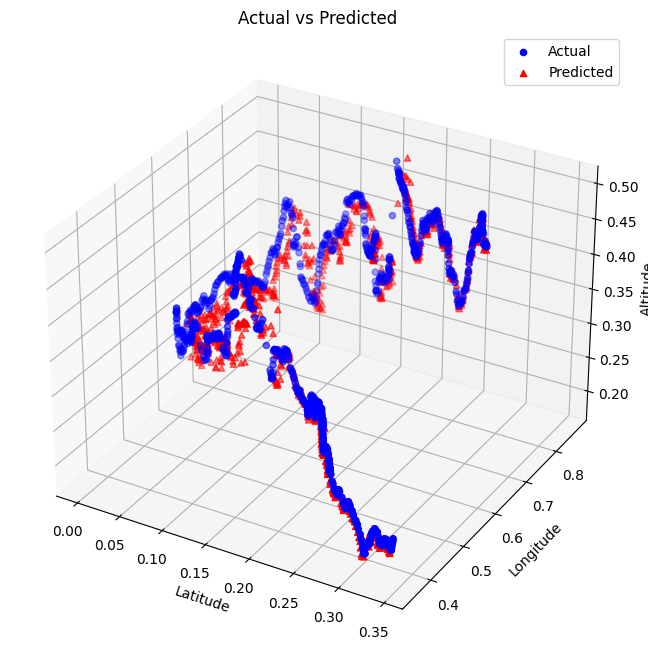

In [ ]:
prediction_visualization(y_true, y_pred)

#### 3. raw 데이터와 predict 데이터 비교

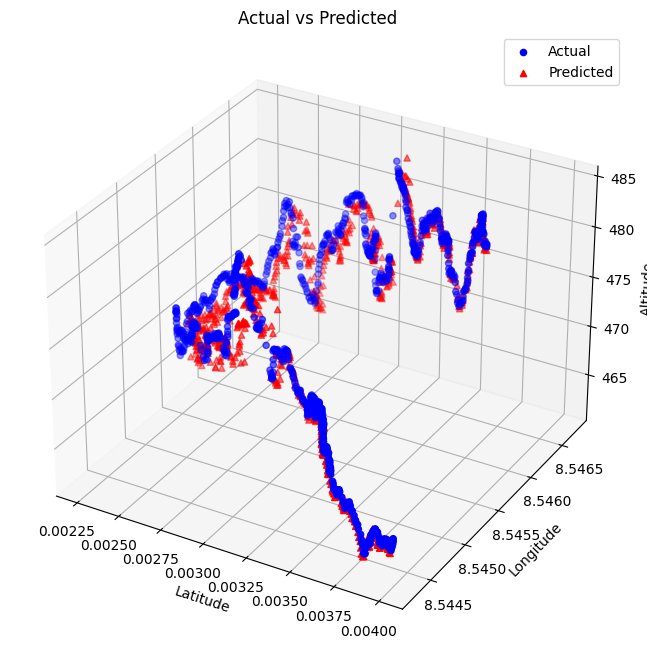

In [ ]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)

In [ ]:
# plot_trajectory(train_data, val_data, test_data)

## Compare Models


### Model 비교 그래프

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_model_comparison(df, num_epochs, y_limits = [0, 0.01]):

    # 그래프 설정
    if num_epochs == 50:
        xticks_interval = 10
    elif num_epochs == 100:
        xticks_interval = 20
    elif num_epochs == 150:
        xticks_interval = 30
    else:
        xticks_interval = num_epochs // 5  # 에포크 수에 따라 5개로 구분

    # 색상 지정
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Plot Train Loss
    axs[0].plot(df['epoch'], df['train_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[0].plot(df['epoch'], df['train_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[0].plot(df['epoch'], df['train_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[0].set_title('Train Loss')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_xticks(range(0, num_epochs + 1, xticks_interval))  # x축 tick 설정
    axs[0].legend()
    axs[0].yaxis.grid(False)  # 가로줄 끄기
    axs[0].xaxis.grid(False)  # 세로줄 끄기

    # Y축 수동 설정
    if y_limits:
        axs[0].set_ylim(y_limits[0], y_limits[1])

    # Plot Valid Loss
    axs[1].plot(df['epoch'], df['valid_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[1].plot(df['epoch'], df['valid_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[1].plot(df['epoch'], df['valid_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[1].set_title('Valid Loss')
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_xticks(range(0, num_epochs + 1, xticks_interval))
    axs[1].legend()
    axs[1].yaxis.grid(False)  # 가로줄 끄기
    axs[1].xaxis.grid(False)  # 세로줄 끄기

    # Y축 수동 설정
    if y_limits:
        axs[1].set_ylim(y_limits[0], y_limits[1])

    # Adjust layout
    plt.tight_layout()
    plt.show()

### 모델 불러오기

In [ ]:
checkpoint = torch.load('./model_output/best_model_epoch_632.pth')
print(checkpoint.keys())

transformer_train_losses = checkpoint['train_losses']
transformer_val_losses = checkpoint['val_losses']

# 손실 값 확인
# print(f"Train Losses: {transformer_train_losses[:5]}")
# print(f"Validation Losses: {transformer_val_losses[:5]}")

dict_keys(['model_state_dict', 'train_losses', 'val_losses', 'optimizer_state_dict'])


<ipython-input-34-72f2a0bbdbe0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/model_output/best_model_epoch_2000.pth')


### Val, Test data LOSS

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, y_limits=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))

    # Y축 수동 설정 (옵션)
    if y_limits:
        plt.ylim(y_limits[0], y_limits[1])

    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss per Epoch', fontsize=14)
    plt.legend()

    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
plt.plot(range(5, num_epochs + 1), train_losses[4:], label='Train Loss')
plt.plot(range(5, num_epochs + 1), val_losses[4:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

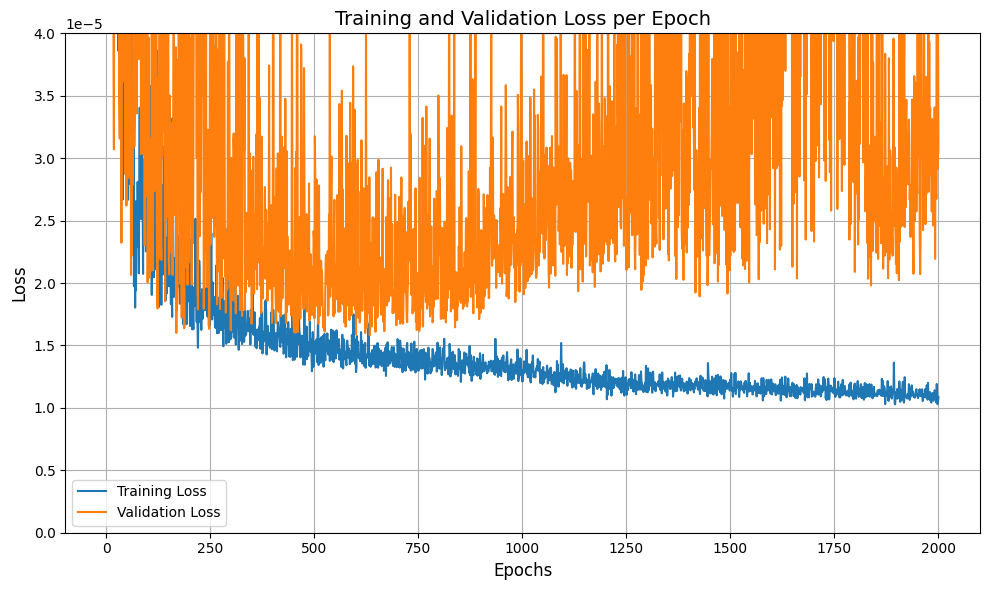

In [ ]:
plot_losses(transformer_train_losses, transformer_val_losses, y_limits = (0, 0.0001))


In [ ]:
print("minimun", min(transformer_val_losses))

# val_losses = history['val_loss']
best_epoch = np.argmin(transformer_val_losses)  # 검증 손실이 가장 낮았던 epoch 찾기
print(f"Best epoch: {best_epoch}, Validation Loss: {val_losses[best_epoch]}")

minimun 1.5823931261472943e-05
Best epoch: 632, Validation Loss: 1.5823931261472943e-05


### 데이터 수집

In [ ]:
data = {
    'epoch': list(range(1, num_epochs + 1)),  # 실제 에포크 수만큼
    'train_loss_1': [x * 1.3 for x in train_losses],
    'train_loss_2': [x * 0.2 for x in train_losses],
    'train_loss_3': transformer_train_losses,
    'valid_loss_1': [x * 1.3 for x in val_losses],
    'valid_loss_2': [x * 0 for x in val_losses],
    'valid_loss_3': transformer_val_losses
}

### 모델 비교 그래프 그리기

In [ ]:
# df = pd.DataFrame(data)

# 그래프 그리기
# plot_model_comparison(df, num_epochs)